### Training an RNN to predict performance of executive RNN

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

class Args():
    def __init__(self):
        self.exp_name = 'gates_search'
        self.var1 = 1
        self.var2 = 0.1
        self.same_rnn = True
        self.use_gates = True
        self.train_to_criterion = True
        self.num_of_tasks = 15
args = Args() 

exp_name = args.exp_name
os.makedirs('./files/'+exp_name, exist_ok=True)

###--------------------------Training configs--------------------------###

# set device
device = 'cuda' # always CPU
# Config
config = {
    # exp:
    'exp_name': exp_name,
    # envs
    'tasks': ['yang19.dlygo-v0',
            'yang19.rtgo-v0',
            'yang19.dlyanti-v0',
            'yang19.go-v0',
            'yang19.dms-v0',
            'yang19.dnms-v0',
            'yang19.dmc-v0',
            'yang19.dnmc-v0',
            'yang19.dm1-v0',
            'yang19.dm2-v0',
            'yang19.ctxdm1-v0',
            'yang19.ctxdm2-v0',
            'yang19.multidm-v0',
            'yang19.anti-v0',
            'yang19.rtanti-v0'
            ],
    'env_kwargs': {'dt': 100},
    'seq_len': 50,
# Training
    'trials_per_task' : 200000,
    'batch_size' : 100,
    'print_every_batches': 100,
    'train_to_criterion': bool(args.train_to_criterion),
    'device': device,
# model
    'use_lstm': False,
    'same_rnn' : bool(args.same_rnn), 
    'use_gates': bool(args.use_gates), 
    'md_mean' : args.var1,
    'md_range': args.var2, #0.1
    'use_external_inputs_mask': False,
    'input_size': 33,
    'hidden_size': 256,
    'sub_size': 128,
    'output_size': 17,
    'num_task': 2,
    'MDeffect': False,
    'md_size': 15,
    'md_active_size': 5,
    'md_dt': 0.001,
# optimizer
    'lr': 1e-4, # 1e-4 for CTRNN, 1e-3 for LSTM
}
config.update({'tasks': config['tasks'][:args.num_of_tasks]})
config.update({'human_task_names': ['{:<6}'.format(tn[7:-3]) for tn in config['tasks']]})
config.update({'md_size': len(config['tasks'])})

exp_signature = config['exp_name'] +f'_{args.var1}_{args.var2}_'+\
    f'{"same_rnn" if config["same_rnn"] else "separate"}_{"gates" if config["use_gates"] else "nogates"}'+\
        f'_{"tc" if config["train_to_criterion"] else "nc"}'
print(exp_signature)

task_seq = []
# Add tasks gradually with rehearsal 1 2 1 2 3 1 2 3 4 ...
task_sub_seqs = [[(i, config['tasks'][i]) for i in range(s)] for s in range(2, len(config['tasks']))] # interleave tasks and add one task at a time
for sub_seq in task_sub_seqs: task_seq+=sub_seq

# Just sequence the tasks serially
simplified_task_seq = [(i, config['tasks'][i]) for i in range(len(config['tasks']))]
task_seq = simplified_task_seq
# print('Task seq to be learned: ', task_seq)


gates_search_1_0.1_same_rnn_gates_tc


In [2]:
# load data
import os
print('cwd: ', os.getcwd())


# file1= './../files/to_om/training_logs_to_om_1.0_0.5_same_rnn_gates_tc.npy'
file1= './../files/to_om/training_logs_to_om_1.0_1.0_same_rnn_nogates_tc.npy'

# label1 = 'no gates'
# label2 = 'with gates \u03bc(1, 0.1)'
label = 'gates 0.5'

training_logs = np.load( file1, allow_pickle=True)
logs = training_logs

num_tasks = len(training_logs) #len(config['tasks'])



cwd:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis


In [3]:
len(logs[4]['stamps'])


400

In [4]:
block_lens = [len(log['stamps']) for log in logs]
print(block_lens)
accumulator = 0
inputs = []
activity = []
outputs = []
labels = []
accuracies = []

change_trials = []
for i in range(num_tasks):
    accumulator += block_lens[i]
    change_trials.append(accumulator)
    inputs.append(np.stack(logs[i]['inputs']))
    outputs.append(np.stack(logs[i]['outputs']))
    activity.append(np.stack(logs[i]['rnn_activity']))
    labels.append(np.stack(logs[i]['labels']))
    accuracies.append(np.stack(logs[i]['accuracy']))
    
print(change_trials)

# inputs = np.concatenate(inputs, axis=0)

outputs = np.concatenate(outputs, axis=0)
labels = np.concatenate(labels , axis=0)
acts = np.concatenate(activity, axis=0)

[1400, 200, 900, 100, 400, 200, 200, 100, 2000, 2000, 2000, 2000, 2000, 200, 100]
[1400, 1600, 2500, 2600, 3000, 3200, 3400, 3500, 5500, 7500, 9500, 11500, 13500, 13700, 13800]


In [5]:
# inputs = np.concatenate(inputs, axis=0)

In [6]:
print(inputs[0].shape)
print(inputs[1].shape)

(1400, 20, 100, 33)
(200, 10, 100, 33)


In [7]:
# np.save('./../files/to_om/pre_stacked_outputs.npy', outputs)
# np.save('./../files/to_om/pre_stacked_labels.npy', labels)
# np.save('./../files/to_om/pre_stacked_acts.npy', acts)

# outputs = np.load('./../files/to_om/pre_stacked_outputs.npy',)
# labels= np.load('./../files/to_om/pre_stacked_labels.npy', )
# acts= np.load('./../files/to_om/pre_stacked_acts.npy', )


In [8]:
labels.shape

(13800, 100, 17)

In [9]:
inputs[4].shape

(400, 32, 100, 33)

In [10]:
if False: # this is compabilbe only of labels anouptputs are not np.stacked
    fig, axes = plt.subplots(1,3, figsize=[6,6])
    trial_no = 5 #
    batch_no = 81 # in batch 601: 10 13 18 are false in all of them, it is too much noise!
    task_no = 9
    axes[0].matshow(inputs [task_no][batch_no][:,trial_no,:].T)
    axes[1].matshow(labels [task_no][batch_no][trial_no,:, np.newaxis])
    axes[2].matshow(outputs[task_no][batch_no][trial_no,:, np.newaxis])
    correct = np.argmax(outputs[task_no][batch_no][trial_no,:], axis =-1) == np.argmax(labels[task_no][batch_no][trial_no,:], axis =-1)
    print ('correct: ', correct)

In [ ]:
plt.matshow(labels[9700, :10,: ].T)

In [ ]:
plt.matshow(acts.reshape([-1, 256])[0:-1:1000])

In [ ]:
print(change_trials)

In [ ]:
acts.shape

In [12]:
# create the task class vector
N = acts.reshape([-1, 256]).shape[0]
ct = [0]+change_trials
ct = [int(c*100) for c in ct]
task_class = np.zeros((N,1))
for i in range(num_tasks):
    task_class[ct[i]:ct[i+1]] = i
    

In [13]:
from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = acts.reshape([-1, 256])[0:-1:sampling_rate]  # shape (n_samples, d)
colors = task_class[0:-1:sampling_rate]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

using cuda
initializing...
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/tsne_torch/tsne_torch.py:124: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  (l, M) = torch.eig(torch.mm(X.t(), X), True)
computing p-values...


  0%|          | 0/6900 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
X.shape[0]
colors.shape

(6900, 1)

In [15]:
colors = task_class[0:-1:sampling_rate]
X_emb.shape

(6900, 2)

In [16]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [ ]:
plt.plot(task_class)

In [ ]:
len(config['human_task_names'])

/tmp/ipykernel_48180/3139570858.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])


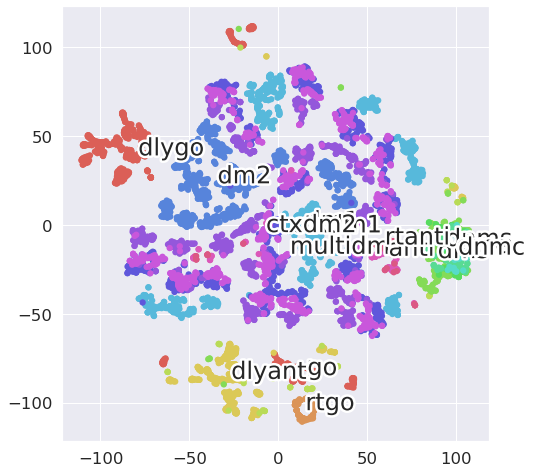

In [18]:
x= X_emb 

num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config['human_task_names'][i], fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


### Start preparing for training

In [19]:
rl = np.argmax(labels, axis=-1)
ro = np.argmax(outputs, axis=-1)

In [20]:
acc = (rl==ro).astype(np.float32)
print('acc shape: ', acc.shape)

acc shape:  (13800, 100)


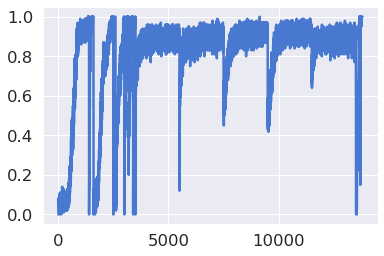

In [21]:
plt.plot(acc.reshape([13800,100,-1]).mean(1))

In [22]:
print('output shapes: ', acc.shape)
print('input shape: ' , acts.shape)

output shapes:  (13800, 100)
input shape:  (13800, 100, 256)


In [39]:
input_length = 50
training_cycles = 2000


In [40]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, hidden = self.gru(inp)
        x = self.linear(out)
        return x, out

0.077: 100%|████████████████████████████████████████████████████████████████████████| 2000/2000 [09:01<00:00,  3.70it/s]


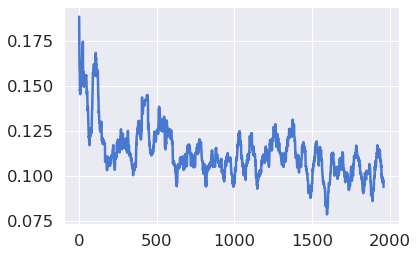

In [41]:
rng = np.random.default_rng()

model = Net(input_size=256, hidden_size=256, output_size=1)
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters())
crit = nn.MSELoss(reduction='mean')
losses = []
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    t = rng.choice(np.array(change_trials[:-1]))
    interval = rng.choice((np.arange(-int(input_length*4), 1)))
    selected_batches = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = np.random.randint(0, acts.shape[0]- input_length)
    selected_batches = range(bi, bi+input_length)

    ins =  torch.tensor(acts[selected_batches]) # (20, 100, 256)
    outs = torch.tensor(acc[selected_batches]) # (20, 100)
    pred, gru_act = model(ins) # Pred torch.Size([20, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(outs, pred.squeeze() )
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())


sloss = np.stack(losses)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)

Now gather all acts[-1, 256] and somehow run them through the GRU but in eval mode. Get all the GRU activations, sample them at the same rate and with the same code and do the tsne.

### testing getting complicated

In [45]:
#eval
model.eval()
gru_acts= []
gru_preds= []

for b in trange (acts.shape[0]//input_length):
    eins= torch.tensor(acts[b:b+input_length])
    gpreds, gacts = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
#     gacts, gpreds = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
    gru_acts.append(gacts.detach().cpu().numpy())
    gru_preds.append(gpreds.detach().cpu().numpy())
model.train()

gru_preds = np.stack(gru_preds)
gru_acts = np.stack(gru_acts)
print(gru_acts.shape)


100%|█████████████████████████████████████████████████████████████████████████████████| 276/276 [00:29<00:00,  9.45it/s]


(276, 50, 100, 256)


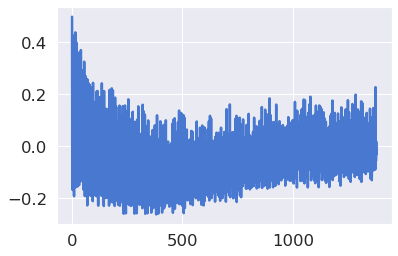

In [51]:
plt.plot(gru_preds.reshape([-1, 1])[0:-1:1000])

In [43]:
from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = gru_acts.reshape([-1, 256])[0:-1:sampling_rate]  # shape (n_samples, d)
colors = task_class[0:-1:sampling_rate]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

using cuda
initializing...
computing p-values...


  0%|          | 0/6900 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

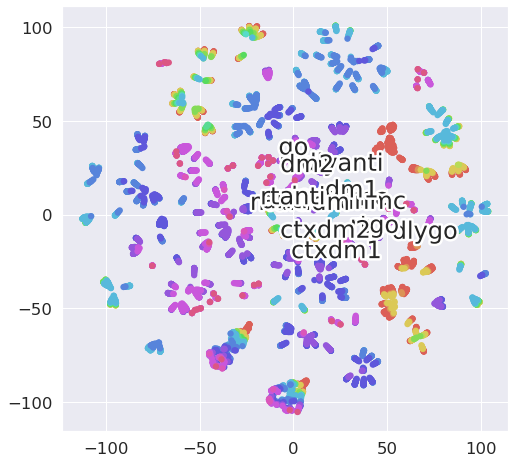

In [44]:
x= X_emb 

num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config['human_task_names'][i], fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


In [ ]:
def extract_accuracies(logs):
    train = []
    test = []
    num_tasks = len(logs)
    for logi in range(num_tasks):
        for task_i in range(num_tasks):
            log = logs[logi]
            if logi== task_i:
                train.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    #                 log['accuracy']task_i])
            else:
                test.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    return(np.stack(train), np.stack(test))


def extract_accuracies_all(logs):
    train = []

    num_tasks = len(logs)
    for logi in range(num_tasks):
        task_tests = []
        for task_i in range(num_tasks):
            log = logs[logi]
            task_tests.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
        train.append(task_tests)
    return(np.stack(train))


# def get_np_acc(logs, num_tasks):
#     logs_tasks_tests_acc = []
#     for logi in range(len(logs)):
#         test_accuracies = []
#         for task_i in range(num_tasks):
#             test_accuracies.append([t[task_i] for t in logs[logi]['accuracy']])
#         logs_tasks_tests_acc.append(np.stack(test_accuracies))

#     ltta = np.stack(logs_tasks_tests_acc)
#     return(ltta)


# tr_acc = get_np_acc(train, 15)
# te_acc = get_np_acc(test, 15)

In [ ]:
# two figs 
plt.close('all')
logs = testing_logs1
num_tasks = len(logs)
title_label = 'Training tasks sequentially ---> \n    ' #+ config['exp_name']
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs1[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, label=label1)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5, label=label1)
        if True:
            log = testing_logs2[logi]
            ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, color='tab:orange', label=label2)

        if li == 0: ax.set_title(config['human_task_names'][logi])
            
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[1, num_tasks-1].legend()

for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        log = testing_logs2[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)

        
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
      mul_gate: {"True" if config["use_gates"] else "False"}\
          {exp_signature}'
axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig(f'./files/{label1}_vs_{label2}.png', dpi=300)

In [ ]:
tr1, te1 = extract_accuracies(testing_logs1)
tr2, te2 = extract_accuracies(testing_logs2)


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8,6))
ax = axes[0,0]
ax.set_title('trained task')
ax.plot(testing_logs1[0]['stamps'], tr1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], tr2.mean(axis=(0)), color='red', label=label2)
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
ax.set_ylim([-0.1, 1.1])
ax.set_ylabel('performance')
ax.set_xlabel('batch #')
ax.legend()

ax = axes[0,1]
ax.set_title('other tasks')
ax.plot(testing_logs1[0]['stamps'], te1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], te2.mean(axis=(0)), color= 'red', label=label2)
ax.set_xlabel('batch #')
ax.legend()

ax.set_ylim([-0.1, 1.1])
# fig.savefig('./files/gates_no_gates_comp.jpg')
fig.savefig(f'./files/{label1}_{label2}comp.png', dpi=600)

logs[0]['accuracy'] has 20 enteries for each time step, and each entry has accuracy of all tasks at that time step.

In [ ]:
tt = extract_accuracies_all(logs)

In [ ]:
def get_diffs(logs, triangle='upper', k=1):
    '''take a log, and return the improvement in the mean accuracy of tasks
    triangle: look at "upper" or "lower" triangle corrospondin to "after" or "before" index task was trained
    k: take from diagonal (0) or above it (1) or below it (-1)'''
    
    tt = extract_accuracies_all(logs)
    tavg = tt.mean(-1)

    tdiff = tavg[1:, :] -  tavg[:-1, :]    
    if triangle == 'upper':
        tri = tdiff[np.triu_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
    elif (triangle == 'lower'):
        tri = tdiff[np.tril_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri    
    
    sorted_diffs = np.sort(tri)
    return(sorted_diffs)


comp1 = get_diffs(testing_logs1, 'upper', 1)
comp2 = get_diffs(testing_logs2, 'upper', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('upper')


In [ ]:
comp1 = get_diffs(testing_logs1, 'lower', 1)
comp2 = get_diffs(testing_logs2, 'lower', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('lower')


In [ ]:
comp1.mean()

In [ ]:
comp2.mean()

In [ ]:
tavg = tt.mean(-1)

In [ ]:
tavg

In [ ]:
tdiff = tavg[1:, :] -  tavg[:-1, :]

In [ ]:
tdiff.shape

In [ ]:
np.triu(tdiff,1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

In [ ]:
np.tril(tdiff,-1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

In [ ]:
ut = tdiff[np.triu_indices_from(tdiff,1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
lt = tdiff[np.tril_indices_from(tdiff,-1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri

In [ ]:
tdiff[np.tril_indices_from(tdiff,-1)]

In [ ]:
tdiff.shape

In [ ]:
plt.bar(range(ut.shape[0]), np.sort(ut))
plt.bar(range(lt.shape[0]), np.sort(lt))


In [ ]:
help(np.sort)

In [ ]:
te1.shape

In [ ]:
with_gates_te = te_acc
with_gates_tr = tr_acc

In [ ]:

fig, ax = plt.subplots(1)
logs = testing_logs

train = []
test = []
for logi in range(num_tasks):
    for li in range(num_tasks):
        log = testing_logs[logi]
        if logi== li:
            train.append(logs[logi]['accuracy'])
        else:
            test.append(logs[logi]['accuracy'])

    
            
train = np.stack(train)
test = np.stack(test)
print(train.shape)
print(test.shape)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0, max_x])
ax.plot(log['stamps'], train.mean(axis=0), linewidth=2)
ax.plot(log['stamps'], test.mean(axis=0), color='grey', linewidth=2)
# if li == 0: ax.set_title(config['human_task_names'][logi])
# if logi == 0: ax.set_ylabel(config['human_task_names'][li])
ax.set_yticklabels([]) 
ax.set_xticklabels([])
        
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
    ax.set_xlabel('batch #')


In [ ]:
np.stack(train[0][0].values())

In [ ]:
logs[0]['accuracy']

In [ ]:
test_accuracies = []
for task_i in range(15):
    test_accuracies.append([test[task_i] for test in logs[0]['accuracy']])


In [ ]:
ta = np.stack(test_accuracies)

In [ ]:

ta.shape

In [ ]:
ta

In [ ]:
task_i = 0
zz= zip(log['stamps'], [test[task_i] for test in logs[0]['accuracy']])

In [ ]:
[print( (z, a)) for z, a in zz]